Name: Antony Krymski

Username: agk-123

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import os

import tensorflow as tf
import tensorflow.keras.backend as K
import keras
from tensorflow.keras import models, optimizers, layers, regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed, GRU, Lambda, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def split(X, y, test_size=0.33):
    # timeseries split 
    i = int(len(X) * (1 - test_size))
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i:], y[i:]
    return X_train, X_test, y_train, y_test

def window(data, timesteps, strides=1):
    # windowing data 
    x = []
    for i in range(0, len(data) - timesteps, strides):
        x.append(data[i:i+timesteps])
    return np.array(x)

def scale(data):
    # min-max scaling
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def plot_training(history):
    # Plot the training and validation loss
    plt.figure(figsize=(14, 7))
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot(x):
    plt.figure(figsize=(14, 7))
    plt.plot(x)
    plt.show()

def returns(a):
    a = np.log(a)
    return np.diff(a, axis=0)
    
def synthetic(N, freq=4, noise=0.2):
    length = np.pi * freq
    data = np.sin(np.arange(0, length, length / N)) + 100.
    data += np.random.normal(0, noise, data.shape)
    # data += np.linspace(0, 10, N)
    return np.expand_dims(data, 1)

def load_data():
    df = pd.read_hdf('~/dev/tensorcap2/data.h5', 'SPY')
    df.index = pd.to_datetime(df.index, unit='s')
    # df = np.rint(df * 100).astype(np.int32)
    return df[['Close']].values.astype(np.float32)

def download(ticker='^GSPC'):
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1=0&period2=9999999999&interval=1d&events=history&includeAdjustedClose=true'
    return pd.read_csv(url, index_col='Date', parse_dates=True)

# Data

# Pre-processing

In [3]:
# BTC = download('BTC-USD')
SPX = download('^VIX')

In [4]:
SPX2 = download()

<Axes: xlabel='Date'>

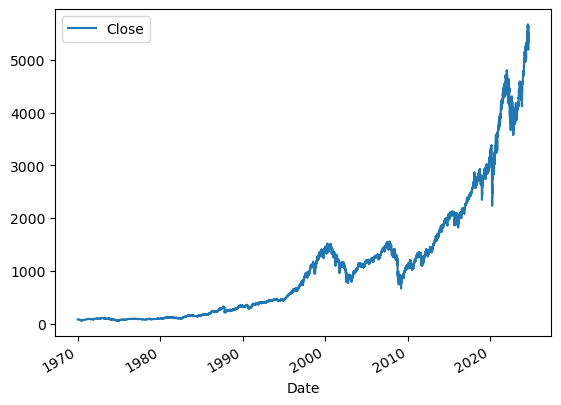

In [5]:
SPX2.plot(y='Close')

In [6]:
X = SPX2[['Close']].values
X = X[~np.isnan(X)]
assert(np.isfinite(X).all() == True)
print(X.shape)

(13782,)


In [8]:
timesteps = 120
features = 1
input_shape = (timesteps, features)
code_size = 32
batch_size = 16
forecast_horizon = 1

In [9]:
# def generate_noisy_sine_wave_shifted(n, amplitude=1.0, frequency=1.0, phase=0.0, noise_amplitude=0.1, shift=2.0):
#     x = np.linspace(0, 2 * np.pi, n)
#     # Sine wave component
#     sine_wave = amplitude * np.sin(frequency * x + phase)
#     # Add Gaussian noise
#     noise = np.random.normal(0, noise_amplitude, n)
#     # noise = 0
#     # Combine sine wave and noise, then shift
#     noisy_sine_wave = sine_wave + noise + shift
    
#     return noisy_sine_wave

# n_points = 10_000
# ts = generate_noisy_sine_wave_shifted(
#     n_points, 
#     amplitude=1.0, 
#     frequency=20, 
#     phase=0.0, 
#     noise_amplitude=0.005, 
#     shift=2.0  # Shift the wave to ensure it's between 1 and 3
# )

# # plot(ts)

In [10]:
# df = pd.DataFrame(ts, columns=['Close'])
# # df.plot()

In [11]:
df = SPX2.dropna()

In [12]:
# compute log returns with a given forecast horizon
y = np.log(df['Close']).diff(forecast_horizon).shift(-forecast_horizon).values
y = np.where(y > 0, 1., 0)

# Make data stationary using log returns
X = pd.DataFrame(index=df.index)
X['returns'] = np.log(df['Close']).diff()
X = X.values

X = X[1:-forecast_horizon]
y = y[1:-forecast_horizon]

# remove outliers
outliers = np.quantile(np.abs(X), 0.999)
X = np.clip(X, -outliers, outliers)

# scale
X = X / np.max(np.abs(X))

x_train, x_test, y_train, y_test = split(X, y)

print('y_train baseline: ', len(np.where(y_train > 0)[0]) / len(y_train))
print('y_test baseline: ', len(np.where(y_test > 0)[0]) / len(y_test))

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

assert(np.isfinite(X).all() == True)
assert(np.isfinite(y).all() == True)

y_train baseline:  0.5207972270363952
y_test baseline:  0.5446350043975374
(9232, 1) (4548, 1)
(9232,) (4548,)


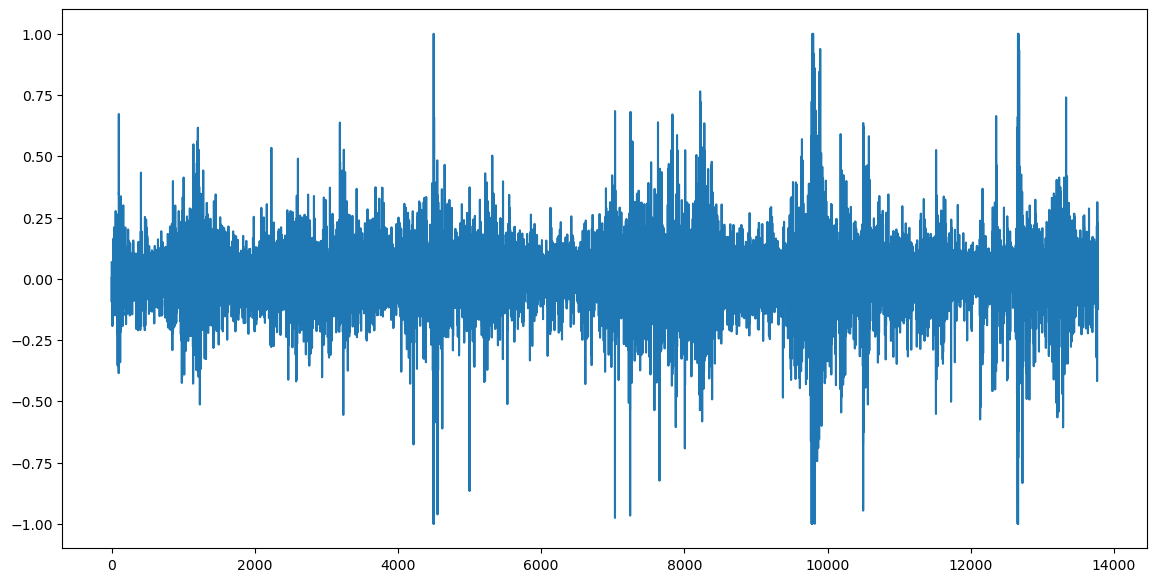

In [13]:
plot(X)

# Data Generation

In [33]:
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, timesteps=timesteps):
        self.timesteps = timesteps
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = data
        self.indexes = np.arange(len(self.data) - timesteps - timesteps)
        # self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size
    
    def get_window(self, idx):
        x = self.data[idx:idx+self.timesteps]
        # return scale(x) * 2. - 1.
        return x

    def __getitem__(self, batch):
        'Generate one batch of data'
        x = []
        y = []
        labels = []
        
        indexes = self.indexes[batch*self.batch_size//2:(batch+1)*self.batch_size//2]

        for idx in indexes:
            x_positive = self.get_window(idx)
            y_positive = self.get_window(idx + self.timesteps)
            
            # y_negative = self.get_window(np.random.choice(self.indexes))

            # if np.random.rand() < 0.5: 
            #     y_negative = y_negative * -1. # vertical flip
            # if np.random.rand() < 0.5:
            #     y_negative = np.flip(y_negative) # horizontal flip
            # if np.random.rand() < 0.5:
            y_negative = np.random.normal(np.mean(x_positive), np.std(x_positive), x_positive.shape[0])
            y_negative = np.expand_dims(np.array(y_negative), axis=-1)
                

            # positive sample
            x.append(x_positive)
            y.append(y_positive)
            labels.append(1)

            # negative sample
            x.append(x_positive)
            y.append(y_negative)
            labels.append(0)
        
        # labels = np.expand_dims(np.array(labels), axis=-1)
        return (np.array(x), np.array(y)), np.array(labels)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [34]:
dg = DataGenerator(x_train, batch_size=16, shuffle=True)

print(len(dg))

# get the first batch
(bx, by), labels = dg.__getitem__(0)
print(f"x shape: {bx.shape}, y shape: {by.shape}, labels shape: {labels.shape}")

562
x shape: (16, 120, 1), y shape: (16, 120, 1), labels shape: (16,)


# Inspecting Windows

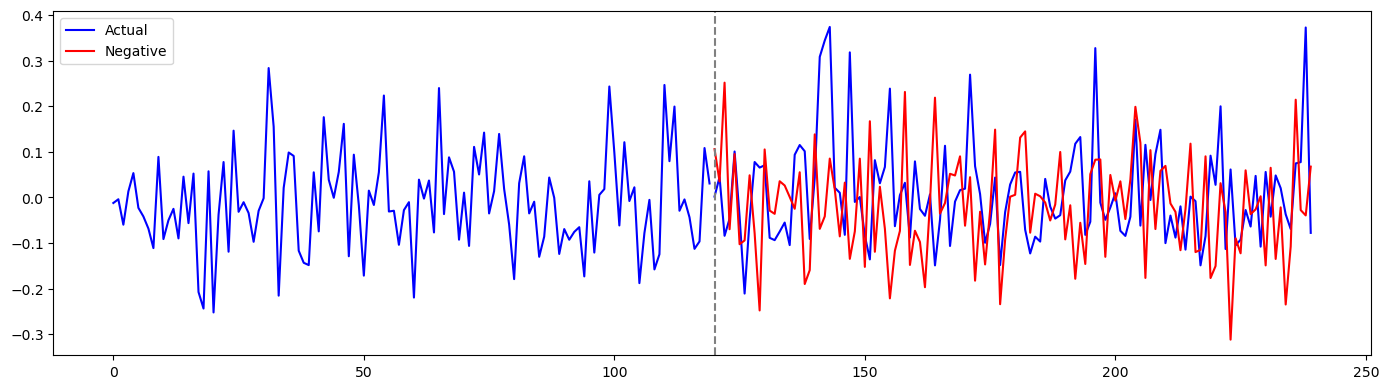

In [35]:
def plot_forecast(x, y, y_pred):
    t1 = np.arange(0, len(x), 1)
    t2 = np.arange(len(x), len(x) + len(y), 1)
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(t1, x, color='blue')
    ax.plot(t2, y, color='blue', label='Actual')
    ax.plot(t2, y_pred, color='red', label='Negative')
    ax.axvline(x=len(x), color='gray', linestyle='--')
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_forecast(bx[0, :, 0], by[0, :, 0], by[1, :, 0])

In [36]:
np.mean(bx[0, :, 0]), np.mean(by[1, :, 0])

(-0.010527096756032259, -0.0219354651756795)

# Model Architecture

In [37]:
def build_encoder(input_shape, code_size):
    input = Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu', padding='same')(input)
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    # x = Conv1D(128, 3, activation='relu', padding='same')(x)
    # x = Conv1D(128, 3, activation='relu', padding='same')(x)
    
    # x = LSTM(64, return_sequences=True)(input)
    # x = LSTM(64, return_sequences=True)(input)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    return Model(input, x, name='encoder')

encoder = build_encoder((timesteps, features), code_size)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 120, 1)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 64)           256       
                                                                 
 conv1d_3 (Conv1D)           (None, 120, 64)           12352     
                                                                 
 encoder_embedding (Dense)   (None, 120, 32)           2080      
                                                                 
Total params: 14,688
Trainable params: 14,688
Non-trainable params: 0
_________________________________________________________________


In [38]:
def build_context(input_shape, code_size):
    '''Build the autoregressive model doing predictions'''
    input = Input(shape=input_shape)
    # x = GRU(64, return_sequences=True, name="context")(input)
    x = LSTM(128, return_sequences=True, name="context")(input)
    x = Dense(code_size, activation="linear", name="preds")(x)
    return Model(input, x, name="context")

context = build_context((timesteps, code_size), code_size)
context.summary()

Model: "context"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 120, 32)]         0         
                                                                 
 context (LSTM)              (None, 120, 128)          82432     
                                                                 
 preds (Dense)               (None, 120, 32)           4128      
                                                                 
Total params: 86,560
Trainable params: 86,560
Non-trainable params: 0
_________________________________________________________________


In [39]:
x_input = Input(input_shape)
encoded = encoder(x_input)

y_pred = context(encoded)

y_input = Input(input_shape)
y_encoded = encoder(y_input)

# y_encoded = y_encoded[:, :forecast_horizon, :]
# y_pred = y_pred[:, :forecast_horizon, :]

output = K.sum(y_encoded * y_pred, axis=-1)
output = K.mean(output, axis=-1, keepdims=True)  # along the temporal dimension
output = K.sigmoid(output)

model = Model(inputs=[x_input, y_input], outputs=output, name='CPC')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "CPC"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 120, 1)]     0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 120, 1)]     0           []                               
                                                                                                  
 encoder (Functional)           (None, 120, 32)      14688       ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 context (Functional)           (None, 120, 32)      86560       ['encoder[0][0]']              

In [40]:
batch_size = 512*2
# batch_size = 256
# epochs = 10

train_gen = DataGenerator(x_train, batch_size=batch_size, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=batch_size, shuffle=True)

In [44]:
history = model.fit(train_gen, batch_size=batch_size, epochs=20, validation_data=test_gen)

Epoch 1/20
8/8 [==============================] - 2s 303ms/step - loss: 0.3868 - binary_accuracy: 0.8198 - val_loss: 0.6961 - val_binary_accuracy: 0.7324
Epoch 2/20
8/8 [==============================] - 2s 300ms/step - loss: 0.3774 - binary_accuracy: 0.8333 - val_loss: 0.7528 - val_binary_accuracy: 0.7180
Epoch 3/20
8/8 [==============================] - 2s 299ms/step - loss: 0.3681 - binary_accuracy: 0.8364 - val_loss: 0.7564 - val_binary_accuracy: 0.7295
Epoch 4/20
8/8 [==============================] - 2s 300ms/step - loss: 0.3565 - binary_accuracy: 0.8448 - val_loss: 0.7591 - val_binary_accuracy: 0.7251
Epoch 5/20
8/8 [==============================] - 2s 299ms/step - loss: 0.3681 - binary_accuracy: 0.8358 - val_loss: 0.7904 - val_binary_accuracy: 0.7249
Epoch 6/20
8/8 [==============================] - 2s 300ms/step - loss: 0.3796 - binary_accuracy: 0.8307 - val_loss: 0.7762 - val_binary_accuracy: 0.7354
Epoch 7/20
8/8 [==============================] - 2s 300ms/step - loss: 0.36

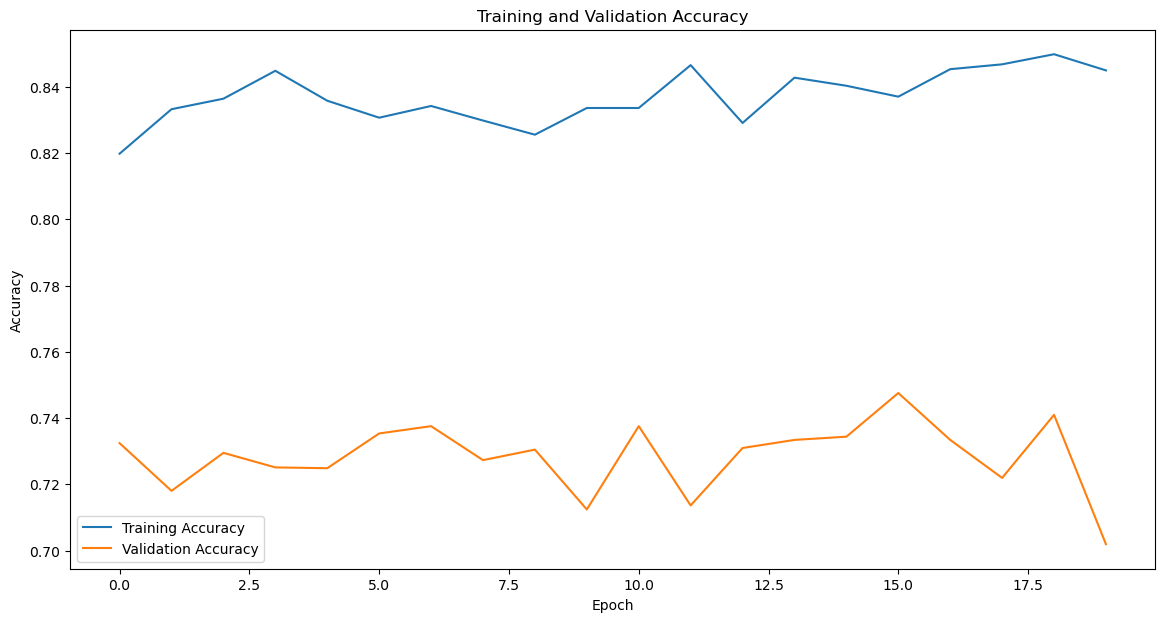

In [45]:
plot_training(history)

In [46]:
encoder.save('encoder_24_08.h5')

# Downstream

## Forecasting

In [47]:
# # BTC = download('BTC-USD')
# SPX = download('VXX')

# timesteps = 120
# features = 1
# input_shape = (timesteps, features)
# code_size = 32
# batch_size = 16
# forecast_horizon = 1

# df = SPX.dropna()

# y = np.log(df['Close']).diff(forecast_horizon).shift(-forecast_horizon).values
# y = np.where(y > 0, 1., 0)

# # Make data stationary using log returns
# X = pd.DataFrame(index=df.index)
# X['returns'] = np.log(df['Close']).diff()
# X = X.values

# X = X[1:-forecast_horizon]
# y = y[1:-forecast_horizon]

# # remove outliers
# outliers = np.quantile(np.abs(X), 0.999)
# X = np.clip(X, -outliers, outliers)

# # scale
# X = X / np.max(np.abs(X))

# x_train, x_test, y_train, y_test = split(X, y)

# print('y_train baseline: ', len(np.where(y_train > 0)[0]) / len(y_train))
# print('y_test baseline: ', len(np.where(y_test > 0)[0]) / len(y_test))

# print(x_train.shape, x_test.shape)
# print(y_train.shape, y_test.shape)

# assert(np.isfinite(X).all() == True)
# assert(np.isfinite(y).all() == True)

In [48]:
def compute_embeddings(x):
    x = window(x, timesteps, 1)
    # for i in range(len(x)):
        # x[i] = scale(x[i]) * 2. - 1.
    return encoder.predict(np.array(x))[:, -1, :]

In [49]:
encoder = load_model('encoder_24_08.h5', compile=True)

x_train_embeds = compute_embeddings(x_train)
x_test_embeds = compute_embeddings(x_test)

y_train_embeds = y_train[timesteps:]
y_test_embeds = y_test[timesteps:]

print(x_train_embeds.shape, x_test_embeds.shape)
print(y_train_embeds.shape, y_test_embeds.shape)

139/139 [==============================] - 0s 2ms/step
(9112, 32) (4428, 32)
(9112,) (4428,)


In [50]:
def scale_embs(x):
    # Normalize each embedding vector to unit norm
    x = x / np.linalg.norm(x, axis=1, keepdims=True)
    return x

In [51]:
x_train_embeds = scale_embs(x_train_embeds)
x_test_embeds = scale_embs(x_test_embeds)

With embeddings

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

fm = LogisticRegression(random_state=42, solver='lbfgs')

fm.fit(x_train_embeds, y_train_embeds)

y_pred = fm.predict(x_test_embeds)

accuracy = accuracy_score(y_test_embeds, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test_embeds, y_pred))

Accuracy: 0.5244
Classification Report:
              precision    recall  f1-score   support

         0.0       0.47      0.30      0.36      2025
         1.0       0.55      0.72      0.62      2403

    accuracy                           0.52      4428
   macro avg       0.51      0.51      0.49      4428
weighted avg       0.51      0.52      0.50      4428



Without embeddings

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

fm = LogisticRegression(random_state=42, solver='lbfgs')

fm.fit(x_train, y_train)

y_pred = fm.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.5279
Classification Report:
              precision    recall  f1-score   support

         0.0       0.44      0.14      0.21      2071
         1.0       0.54      0.86      0.66      2477

    accuracy                           0.53      4548
   macro avg       0.49      0.50      0.44      4548
weighted avg       0.50      0.53      0.46      4548



## Features analysis

427/427 [==============================] - 1s 2ms/step


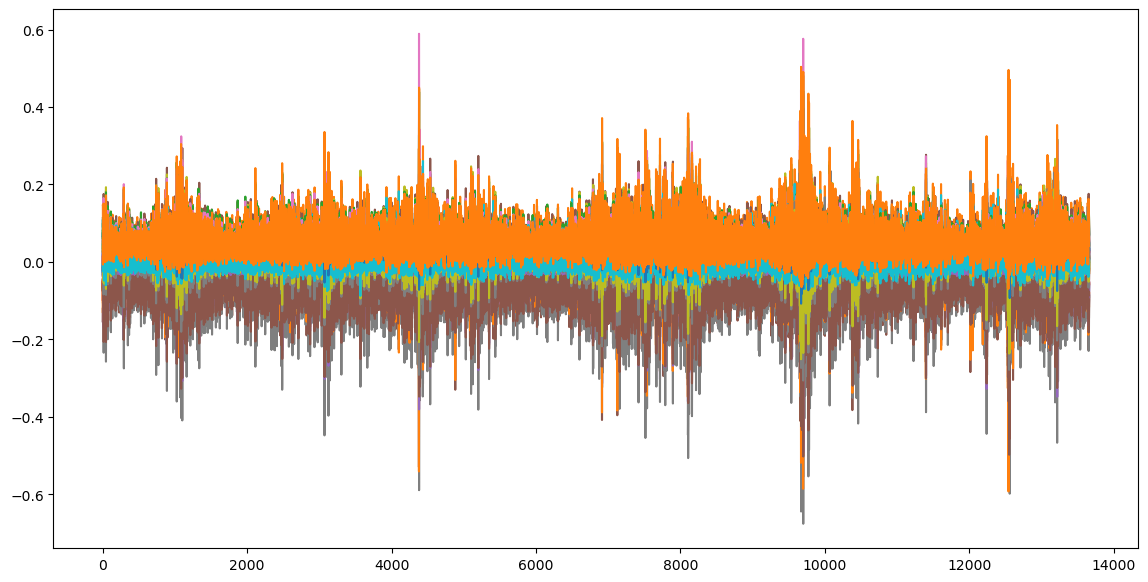

In [54]:
features = compute_embeddings(X)
plot(features)

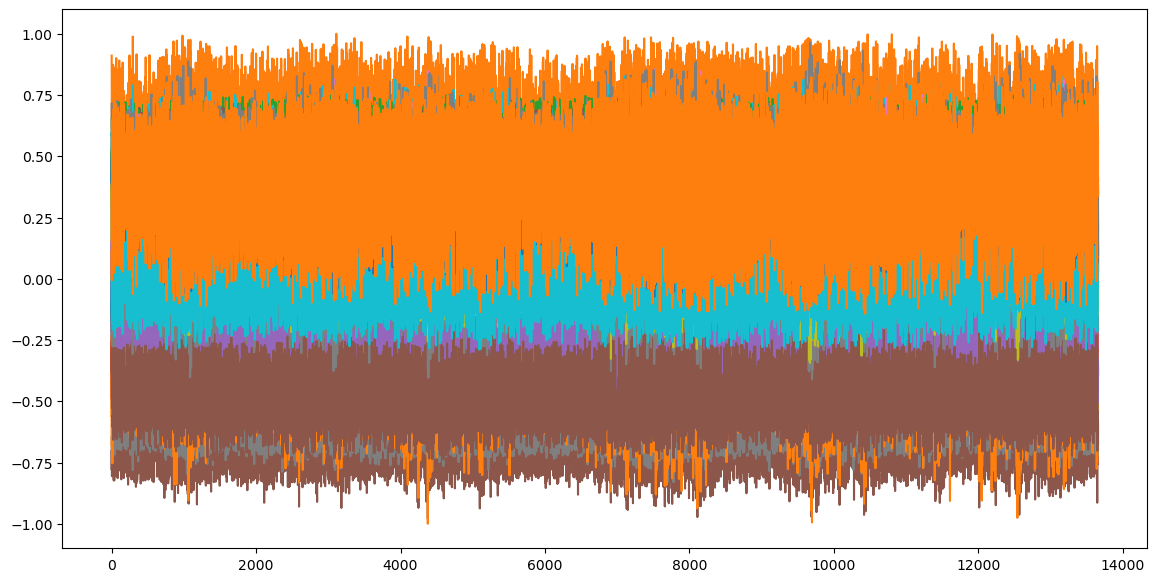

In [55]:
features_s = scale_embs(features)
features_s = scale(features_s) * 2. - 1.
plot(features_s)

In [56]:
# import numpy as np
# from numpy.linalg import matrix_rank, det
# from scipy.linalg import svdvals

# # Assume 'embeddings' is your NumPy array of shape (n_samples, n_features)
# embeddings = features  # Replace with your embeddings

# # 1. Check the Rank of the Matrix
# rank = matrix_rank(embeddings)
# print(f"Rank of the embedding matrix: {rank}")
# print(f"Number of embeddings (rows): {embeddings.shape[0]}")
# print(f"Dimensionality of embeddings (columns): {embeddings.shape[1]}")

# if rank == min(embeddings.shape):
#     print("The embeddings are linearly independent.")
# else:
#     print("The embeddings are not linearly independent.")

# # 2. Check the Determinant of the Gram Matrix
# gram_matrix = np.dot(embeddings.T, embeddings)  # G = X^T X
# determinant = np.linalg.det(gram_matrix)

# print(f"Determinant of the Gram matrix: {determinant}")
# if determinant != 0:
#     print("The embeddings are linearly independent.")
# else:
#     print("The embeddings are linearly dependent.")

# # 3. Check the Condition Number
# condition_number = np.linalg.cond(embeddings)
# print(f"Condition number of the embedding matrix: {condition_number}")

# if condition_number < 1 / np.finfo(embeddings.dtype).eps:
#     print("The embeddings are close to linearly independent.")
# else:
#     print("The embeddings are close to being linearly dependent.")

# # 4. Singular Value Decomposition (SVD) for more insights
# singular_values = svdvals(embeddings)
# print(f"Singular values: {singular_values}")

# if np.min(singular_values) > 1e-10:
#     print("The singular values suggest linear independence.")
# else:
#     print("The singular values suggest potential linear dependence.")


In [57]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import numpy as np

# # Assume 'features' is your NumPy array of shape (n_samples, n_features)
# # and 'features' is standardized if needed

# # 1. Standardize the data (if needed)
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)

# # 2. Apply PCA
# n_components = 16  # Number of components to keep
# pca = PCA(n_components=n_components)

# # Fit PCA on the standardized data
# features_pca = pca.fit_transform(features_scaled)

# # 3. Inspect the explained variance ratio
# explained_variance = pca.explained_variance_ratio_
# print(f"Explained variance by each principal component: {explained_variance}")
# print(f"Cumulative explained variance: {np.cumsum(explained_variance)}")

# # 4. Plot the cumulative explained variance
# plt.figure(figsize=(8, 6))
# plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance by Number of Principal Components')
# plt.grid()
# plt.show()


In [58]:
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # Then apply t-SNE for visualization
# tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
# embeddings_tsne = tsne.fit_transform(features)

# # Plot the t-SNE results
# plt.figure(figsize=(10, 8))
# plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c='blue', alpha=0.5)
# plt.title('t-SNE visualization of CPC embeddings')
# plt.show()

In [59]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import matplotlib.pyplot as plt

# # Elbow Method to determine the optimal number of clusters
# inertia = []
# silhouette_scores = []
# K = range(2, 32)  # Range of number of clusters to try

# for k in K:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(features)
#     inertia.append(kmeans.inertia_)
    
#     # Compute the silhouette score for each 
#     silhouette_avg = silhouette_score(features, kmeans.labels_)
#     silhouette_scores.append(silhouette_avg)

# # Plot the Elbow Curve
# plt.figure(figsize=(12, 6))
# plt.plot(K, inertia, 'bo-', markersize=8)
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal k')
# plt.grid(True)
# plt.show()

# # Plot the Silhouette Scores
# plt.figure(figsize=(12, 6))
# plt.plot(K, silhouette_scores, 'bo-', markersize=8)
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score for Optimal k')
# plt.grid(True)
# plt.show()


In [60]:
# from sklearn.cluster import KMeans

# # Apply K-means clustering
# kmeans = KMeans(n_clusters=8)  # Adjust the number of clusters based on your data
# clusters = kmeans.fit_predict(features)

# # Visualize the clusters using the t-SNE embeddings
# plt.figure(figsize=(10, 8))
# plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
# plt.title('Cluster analysis of CPC embeddings')
# plt.show()


## RL

In [64]:
from tensorflow.keras import optimizers, callbacks

# Define a learning rate schedule function
def learning_rate_schedule(epoch, lr):

    if epoch % 10 == 0 and epoch > 0:
        return lr * 0.5
    return lr

# Define the model architecture
def create_model(input_shape):
    model = models.Sequential([
        Input(shape=(input_shape,)),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='tanh')
        # layers.Lambda(lambda x: -tf.math.abs(x))
    ])
    return model

# Function to calculate Sharpe ratio
def sharpe_ratio(returns):
    mean_return = tf.reduce_mean(returns)
    std_return = tf.math.reduce_std(returns)
    sharpe = mean_return / std_return
    return sharpe * np.sqrt(252)  # Annualize Sharpe ratio

# Custom training loop with gradient ascent for a single batch
def train_step(model, log_returns, features, optimizer):
    with tf.GradientTape() as tape:
        allocations = model(features, training=True)  # Forward pass
        # Shift allocations back by one period
        portfolio_returns = log_returns[1:] * allocations[:-1, 0]
        # portfolio_returns = tf.reduce_sum(log_returns[1:] * allocations[:-1], axis=1)
        sharpe = sharpe_ratio(portfolio_returns)
        loss = -sharpe  # Negative Sharpe ratio (to maximize it)
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # print(sharpe.shape, portfolio_returns.shape, allocations.shape)
    return sharpe

def train_rl(features, log_returns, epochs_per_step=1, lr=0.001, window_size=120):
    assert len(log_returns) == len(features)
    allocations = np.zeros_like(log_returns)
    
    model = create_model(features.shape[1])
    optimizer = optimizers.legacy.Adam(learning_rate=lr, clipnorm=1.0)
    
    train_sharpe_history = []
    test_sharpe_history = []

    # Rolling window online learning
    for i in range(window_size, len(log_returns), window_size):
        
        # Train the model up to the current window
        for epoch in range(epochs_per_step):
            # new_lr = learning_rate_schedule(epoch + i // window_size * epochs_per_step, optimizer.learning_rate.numpy())
            # tf.keras.backend.set_value(optimizer.learning_rate, new_lr)
            
            sharpe = train_step(model, log_returns[:i], features[:i], optimizer)
            
        if i >= len(log_returns) - window_size:
            window_size = len(log_returns) - i
        
        # Predict next window
        allocations[i:i+window_size] = model.predict(features[i:i+window_size])[:, 0]

        # Compute Sharpe ratio achieved so far
        # Shift allocations back by one period for testing as well
        sharpe_test = sharpe_ratio(log_returns[1:i+window_size] * allocations[:i+window_size-1])

        # Append Sharpe ratios to history
        train_sharpe_history.append(sharpe.numpy())  # Convert TensorFlow tensor to a NumPy array
        test_sharpe_history.append(sharpe_test.numpy())
        
        print(f'Step {i}/{len(log_returns)}, Train Sharpe: {sharpe:.4f}, Test Sharpe {sharpe_test:.4f}')

    return allocations, model, (train_sharpe_history, test_sharpe_history)


In [65]:
import gc
gc.collect()

29527

In [66]:
# features_scaled = scale_embs(features)
log_returns = np.log(df['Close']).diff().values

# print(X.shape, features_scaled.shape, log_returns.shape)

allocations, model, history = train_rl(features_s, log_returns[1+timesteps:-forecast_horizon], epochs_per_step=1, lr=0.0001, window_size=120)

4/4 [==============================] - 0s 8ms/step
Step 120/13660, Train Sharpe: 4.0592, Test Sharpe 1.8913
4/4 [==============================] - 0s 2ms/step
Step 240/13660, Train Sharpe: 3.2635, Test Sharpe 0.2466
4/4 [==============================] - 0s 1ms/step
Step 360/13660, Train Sharpe: 2.0899, Test Sharpe 0.9282
4/4 [==============================] - 0s 1ms/step
Step 480/13660, Train Sharpe: 2.2574, Test Sharpe 0.9644
4/4 [==============================] - 0s 1ms/step
Step 600/13660, Train Sharpe: 1.9627, Test Sharpe 0.3869
4/4 [==============================] - 0s 1ms/step
Step 720/13660, Train Sharpe: 1.1613, Test Sharpe 0.0498
4/4 [==============================] - 0s 1ms/step
Step 840/13660, Train Sharpe: 0.7153, Test Sharpe -0.4696
4/4 [==============================] - 0s 1ms/step
Step 960/13660, Train Sharpe: 0.4519, Test Sharpe -0.4705
4/4 [==============================] - 0s 2ms/step
Step 1080/13660, Train Sharpe: 0.3628, Test Sharpe -0.0438
4/4 [===================

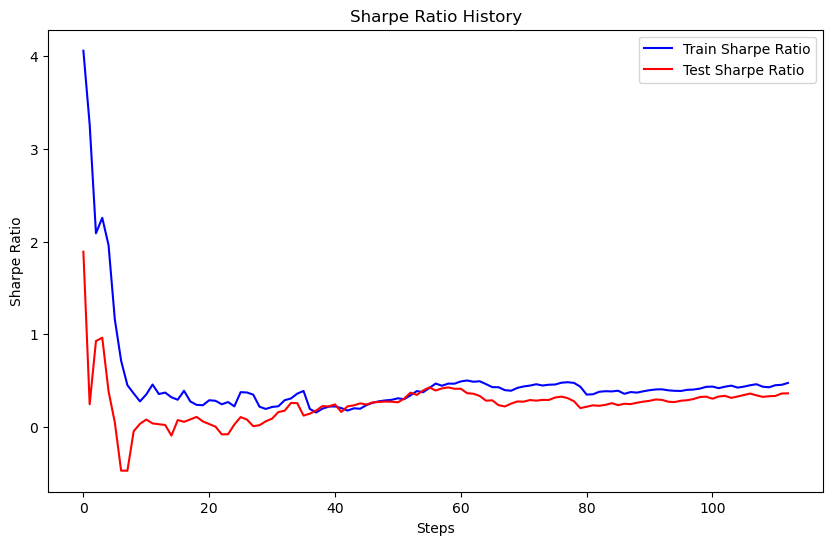

In [67]:
# Plotting the Sharpe ratio history
plt.figure(figsize=(10, 6))
plt.plot(history[0], label='Train Sharpe Ratio', color='blue')
plt.plot(history[1], label='Test Sharpe Ratio', color='red')
plt.xlabel('Steps')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio History')
plt.legend()
plt.show()

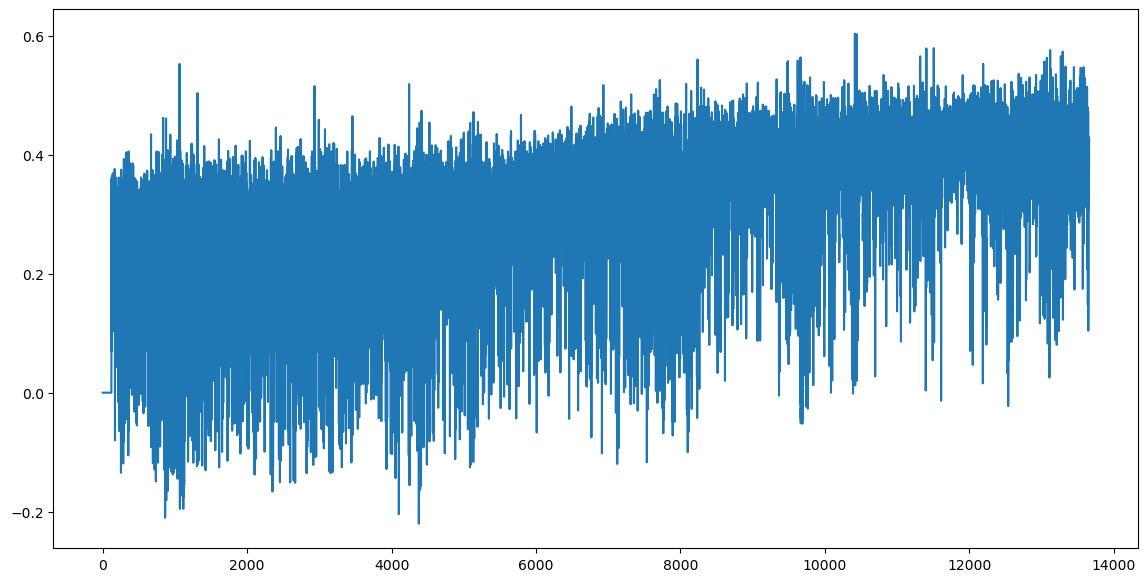

In [68]:
plot(allocations)

(13782,) (13660,)
Benchmark Sharpe Ratio: 0.4614449207607428
Strategy Sharpe Ratio: 0.3643140912022652


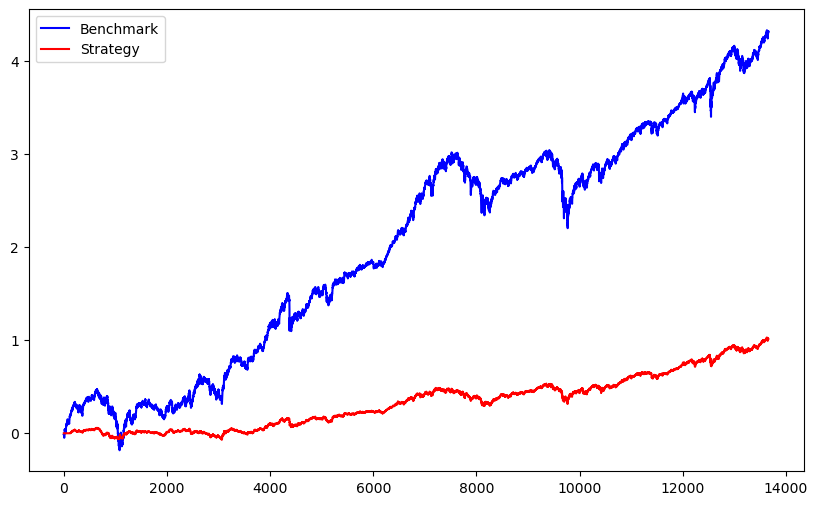

In [69]:
print(log_returns.shape, allocations.shape)

test_idx = int(len(log_returns) * 0.5)
test_idx = 0

a = log_returns[1+timesteps:-forecast_horizon]

# Shift allocations back by one period
portfolio_returns = log_returns[2+timesteps:-forecast_horizon] * allocations[:-1]
# portfolio_returns = log_returns[1:] * allocations[:-1]

print(f'Benchmark Sharpe Ratio: {sharpe_ratio(log_returns[1+timesteps+test_idx:-forecast_horizon])}')
print(f'Strategy Sharpe Ratio: {sharpe_ratio(portfolio_returns[test_idx:])}')

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(log_returns[1+timesteps+test_idx:-forecast_horizon]), label='Benchmark', color='blue')
plt.plot(np.cumsum(portfolio_returns[test_idx:]), label='Strategy', color='red')
plt.legend()


In [79]:
# model.save('model_24_08_BEST.h5')

# IGNORE FROM HERE

In [72]:
# Create the model
log_returns = X[:, 0]
print(log_returns.shape, features.shape)
assert len(log_returns) == len(features)
allocations = np.zeros_like(log_returns)

(13660,) (13660, 32)


In [73]:
model = create_model(features.shape[1])
optimizer = optimizers.legacy.Adam(learning_rate=learning_rate)

best_sharpe = -np.inf
best_model_path = 'best_model.h5'

In [74]:
train_sharpe_history = []
test_sharpe_history = []

# Rolling window online learning
for i in range(window_size, len(log_returns), window_size):
    
    # Train the model up to the current window
    for epoch in range(epochs_per_step):
        sharpe = train_step(model, log_returns[:i], features[:i], optimizer)
        
    if i >= len(log_returns) - window_size:
        window_size = len(log_returns) - i
    
    # Predict next window
    allocations[i:i+window_size] = model.predict(features[i:i+window_size])[:, 0]

    # Compute Sharpe ratio achieved so far
    # Shift allocations back by one period for testing as well
    sharpe_test = sharpe_ratio(log_returns[:i+window_size-1] * allocations[1:i+window_size])
    
    # Check for extreme losses in the case of short positions
    extreme_case_return = log_returns[:i+window_size-1] * allocations[1:i+window_size]
    if np.min(extreme_case_return) <= -1:
        # add colour to print statement
        print("\033[91mWarning: Loss exceeds 100% in at least one case, check allocation logic!\033[0m")

    # Append Sharpe ratios to history
    train_sharpe_history.append(sharpe.numpy())  # Convert TensorFlow tensor to a NumPy array
    test_sharpe_history.append(sharpe_test.numpy())
    
    print(f'Step {i}/{len(log_returns)}, Train Sharpe: {sharpe:.4f}, Test Sharpe {sharpe_test:.4f}')
    
    # Save the model if the test Sharpe ratio is the best so far
    if sharpe_test > best_sharpe:
        best_sharpe = sharpe_test
        model.save(best_model_path)
        print(f'Best model saved with Sharpe ratio: {best_sharpe:.4f}')


4/4 [==============================] - 0s 7ms/step
Step 120/13660, Train Sharpe: 3.4617, Test Sharpe 2.2818
Best model saved with Sharpe ratio: 2.2818
4/4 [==============================] - 0s 1ms/step
Step 240/13660, Train Sharpe: 3.2946, Test Sharpe -0.0291
4/4 [==============================] - 0s 1ms/step
Step 360/13660, Train Sharpe: 1.3050, Test Sharpe 1.0272
4/4 [==============================] - 0s 1ms/step
Step 480/13660, Train Sharpe: 1.8928, Test Sharpe 1.1123
4/4 [==============================] - 0s 1ms/step
Step 600/13660, Train Sharpe: 1.8136, Test Sharpe 0.6413
4/4 [==============================] - 0s 1ms/step
Step 720/13660, Train Sharpe: 1.2855, Test Sharpe 0.5725
4/4 [==============================] - 0s 1ms/step
Step 840/13660, Train Sharpe: 1.1078, Test Sharpe 0.0125
4/4 [==============================] - 0s 1ms/step
Step 960/13660, Train Sharpe: 0.4713, Test Sharpe -0.6768
4/4 [==============================] - 0s 2ms/step
Step 1080/13660, Train Sharpe: -0.2638, 

KeyboardInterrupt: 

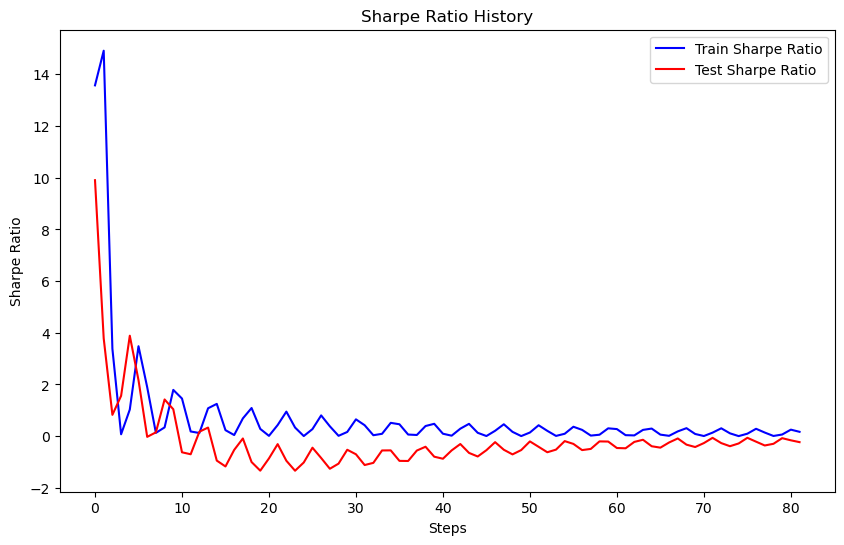

In [140]:
# Plotting the Sharpe ratio history
plt.figure(figsize=(10, 6))
plt.plot(history[0], label='Train Sharpe Ratio', color='blue')
plt.plot(history[1], label='Test Sharpe Ratio', color='red')
plt.xlabel('Steps')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio History')
plt.legend()
plt.show()

<Figure size 500x300 with 0 Axes>

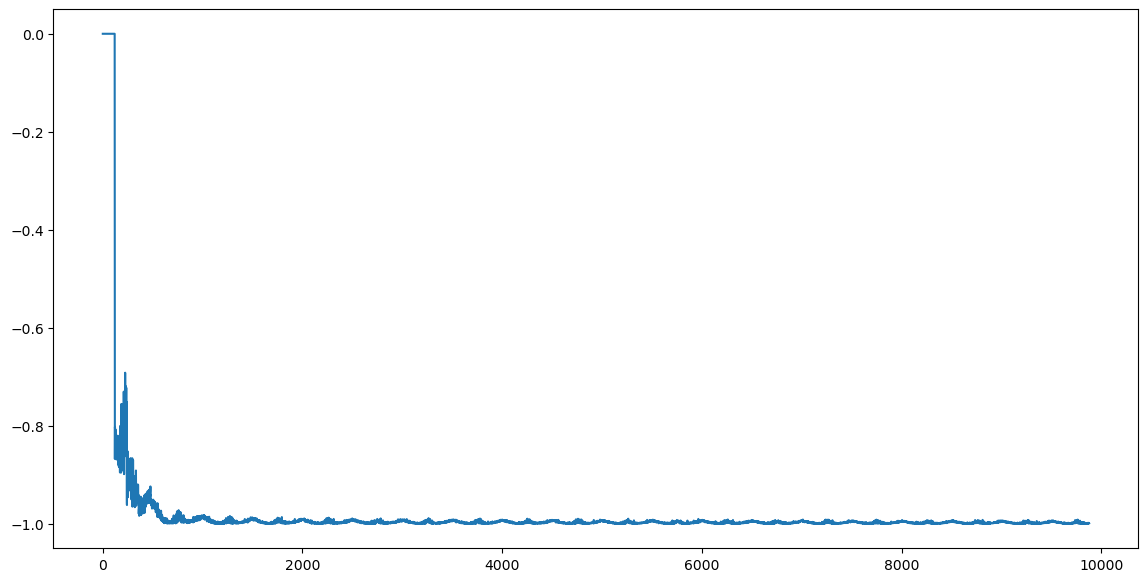

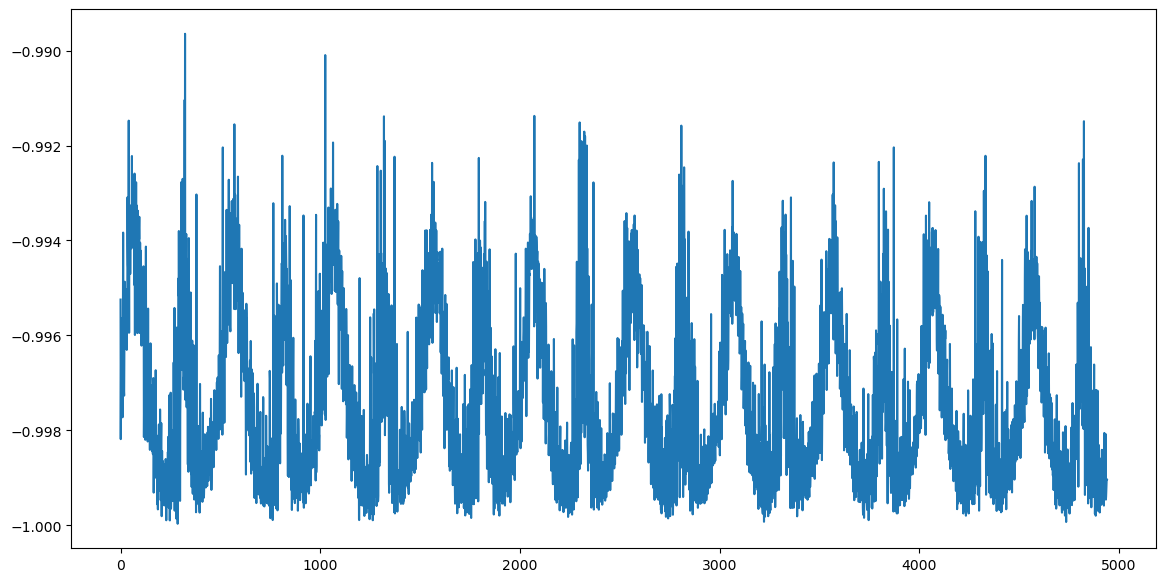

In [64]:
test_idx = int(len(log_returns) * 0.5)

plt.figure(figsize=(5, 3))
plot(allocations)
plot(allocations[test_idx:])

Test Set Sharpe Ratio: 0.1453
Benchmark Sharpe Ratio: -0.1447


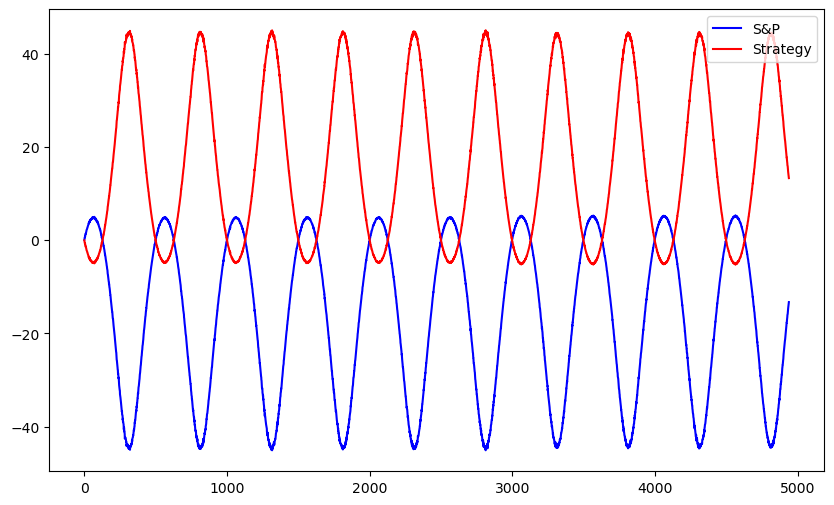

In [65]:
# Shift allocations back by one period
portfolio_returns = log_returns[1:] * allocations[:-1]

print(f'Test Set Sharpe Ratio: {sharpe_ratio(portfolio_returns[-test_idx:]):.4f}')
print(f'Benchmark Sharpe Ratio: {sharpe_ratio(log_returns[-test_idx:]):.4f}')

plt.figure(figsize=(10, 6))
plt.plot(np.arange(test_idx), np.cumsum(log_returns[-test_idx:]), label='S&P', color='blue')
plt.plot(np.arange(test_idx), np.cumsum(portfolio_returns[-test_idx:]), label='Strategy', color='red')
plt.legend()


In [218]:
def backtester(allocations, prices, initial_capital=100000):
    # Initialize capital
    capital = initial_capital
    capital_history = [capital]
    
    # Loop over each time step to calculate portfolio value
    for t in range(1, len(prices)):
        # Calculate the change in portfolio value based on price change and allocation
        price_change = (prices[t] / prices[t - 1]) - 1  # Relative price change
        daily_return = price_change * allocations[t - 1]  # Apply previous day's allocation
        
        # Update capital based on the daily return
        capital = capital * (1 + daily_return)
        
        # Check if capital has gone to zero or below
        if capital <= 0:
            print(f"Capital has been depleted on day {t}. Ending simulation.")
            break
        
        capital_history.append(capital)
    
    return np.array(capital_history)

# prices = X[:, 0]
prices = SPX[['Close']].values
prices = prices[121:]
print(prices.shape, allocations.shape)

initial_capital = 100_000  # Starting with $100,000
capital_history = backtester(allocations, prices, initial_capital)

spx_history = backtester(log_returns, prices, initial_capital)


(13659, 1) (13659,)


/var/folders/k0/x79hb9j52592z6fm_kpxykrr0000gn/T/ipykernel_69853/89282746.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(capital_history)


In [183]:
# def short_only_backtester(prices, initial_capital=100000, short_percentage=0.10):
#     capital = initial_capital
#     capital_history = [capital]
    
#     for t in range(1, len(prices)):
#         price_change = (prices[t] / prices[t - 1]) - 1
#         daily_return = -price_change * short_percentage
#         capital = capital * (1 + daily_return)
#         if capital <= 0:
#             print(f"Capital has been depleted on day {t}. Ending simulation.")
#             break
        
#         capital_history.append(capital)
    
#     return np.array(capital_history)

# short_only_history = short_only_backtester(prices, initial_capital, short_percentage=0.10)
# strategy_returns = np.diff(capital_history) / capital_history[:-1]
# short_only_returns = np.diff(short_only_history) / short_only_history[:-1]

# your_strategy_sharpe = sharpe_ratio(strategy_returns)
# short_only_sharpe = sharpe_ratio(short_only_returns)

In [1682]:
# Function to create LSTM model
def create_lstm_model(timesteps, features):
    model = models.Sequential([
        Input(shape=(timesteps, features)),
        layers.LSTM(16, return_sequences=True),
        layers.LSTM(16, return_sequences=False),
        layers.Dense(1, activation='tanh')
    ])
    return model

# Function to calculate Sharpe ratio
def sharpe_ratio(returns):
    mean_return = tf.reduce_mean(returns)
    std_return = tf.math.reduce_std(returns)
    sharpe = mean_return / std_return
    return sharpe * np.sqrt(252.0)

# Custom training loop with gradient ascent for a single batch
def train_step(model, log_returns, features, optimizer):
    with tf.GradientTape() as tape:
        allocations = model(features, training=True)  # Forward pass
        # Calculate portfolio returns based on allocations
        portfolio_returns = log_returns[1:] * allocations[:-1]
        sharpe = sharpe_ratio(portfolio_returns)
        loss = -sharpe  # Negative Sharpe ratio (to maximize it)
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return sharpe

# Function to window the time series data
def window_data(data, window_size):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
    return np.array(X)

# Hyperparameters
window_size = 120
epochs_per_step = 1
learning_rate = 0.01

log_returns = X[:, 0]  # Assuming X is the time series data

# # Scale the entire dataset between -1 and 1
# min_val = np.min(log_returns)
# max_val = np.max(log_returns)
# scaled_log_returns = 2 * (log_returns - min_val) / (max_val - min_val) - 1

features = window_data(log_returns, window_size)

log_returns = log_returns[window_size:]

# Ensure that the lengths match
assert len(log_returns) == len(features)

# Create the LSTM model
model = create_lstm_model(window_size, 1)
optimizer = optimizers.legacy.Adam(learning_rate=learning_rate)

best_sharpe = -np.inf
best_model_path = 'best_lstm_rl_model.h5'
train_sharpe_history = []
test_sharpe_history = []

allocations = np.zeros_like(log_returns)


In [1683]:
# Rolling window online learning
for i in range(window_size, len(log_returns), window_size):
    
    # Train the model up to the current window
    for epoch in range(epochs_per_step):
        sharpe = train_step(model, log_returns[:i], features[:i], optimizer)
    
    if i >= len(log_returns) - window_size:
        window_size = len(log_returns) - i
    # Predict next window
    allocations[i:i+window_size] = model.predict(features[i:i+window_size])[:, 0]

    # Compute Sharpe ratio achieved so far
    # Shift allocations back by one period for testing as well
    portfolio_returns = log_returns[:i+window_size-1] * allocations[1:i+window_size]
    sharpe_test = sharpe_ratio(portfolio_returns)
    
    # Check for extreme losses in the case of short positions
    extreme_case_return = portfolio_returns
    if np.min(extreme_case_return) <= -1:
        print("Warning: Loss exceeds 100% in at least one case, check allocation logic!")

    # Append Sharpe ratios to history
    train_sharpe_history.append(sharpe.numpy())  # Convert TensorFlow tensor to a NumPy array
    test_sharpe_history.append(sharpe_test.numpy())
    
    print(f'Step {i}/{len(log_returns)}, Train Sharpe: {sharpe:.4f}, Test Sharpe {sharpe_test:.4f}')
    
    # Save the model if the test Sharpe ratio is the best so far
    if sharpe_test > best_sharpe:
        best_sharpe = sharpe_test
        model.save(best_model_path)
        print(f'Best model saved with Sharpe ratio: {best_sharpe:.4f}')
        

4/4 [==============================] - 3s 236ms/step
Step 120/13539, Train Sharpe: -1.2900, Test Sharpe -1.3976
Best model saved with Sharpe ratio: -1.3976
4/4 [==============================] - 0s 68ms/step
Step 240/13539, Train Sharpe: 0.0436, Test Sharpe 0.9843
Best model saved with Sharpe ratio: 0.9843
4/4 [==============================] - 0s 53ms/step
Step 360/13539, Train Sharpe: 1.2926, Test Sharpe 1.1165
Best model saved with Sharpe ratio: 1.1165
4/4 [==============================] - 0s 60ms/step
Step 480/13539, Train Sharpe: 1.3286, Test Sharpe 0.3670
4/4 [==============================] - 0s 66ms/step
Step 600/13539, Train Sharpe: 0.7734, Test Sharpe 0.3513
4/4 [==============================] - 0s 60ms/step
Step 720/13539, Train Sharpe: 0.6813, Test Sharpe -0.2982
4/4 [==============================] - 0s 78ms/step
Step 840/13539, Train Sharpe: 0.0627, Test Sharpe -1.0554
4/4 [==============================] - 0s 61ms/step
Step 960/13539, Train Sharpe: -0.6626, Test Sharpe

KeyboardInterrupt: 

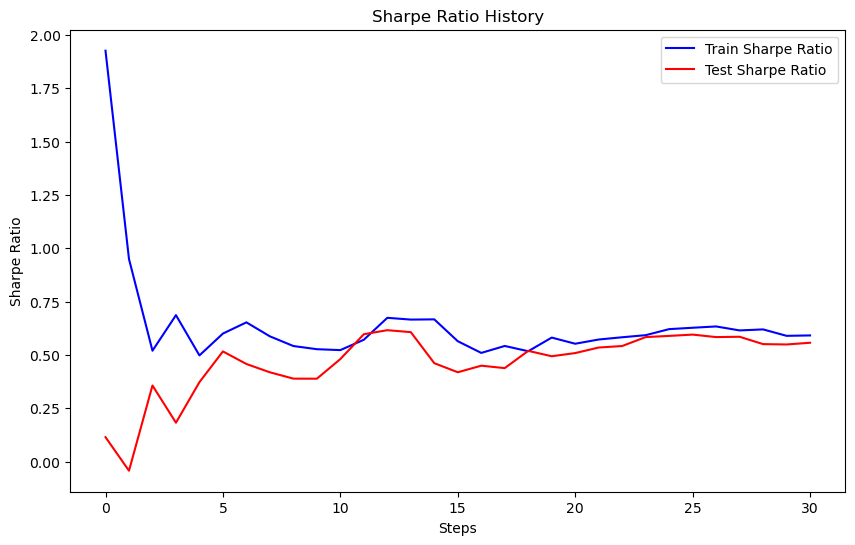

In [1383]:
plt.figure(figsize=(10, 6))
plt.plot(train_sharpe_history, label='Train Sharpe Ratio', color='blue')
plt.plot(test_sharpe_history, label='Test Sharpe Ratio', color='red')
plt.xlabel('Steps')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio History')
plt.legend()
plt.show()

In [1384]:
# Shift allocations back by one period
portfolio_returns = log_returns[1:] * allocations[:-1]

# Calculate Sharpe ratio for the test set, considering the shifted allocations
print(f'Test Set Sharpe Ratio: {sharpe_ratio(portfolio_returns[1:]):.4f}')
print(f'Benchmark Sharpe Ratio: {sharpe_ratio(log_returns):.4f}')

Test Set Sharpe Ratio: 0.5438
Benchmark Sharpe Ratio: 0.5844


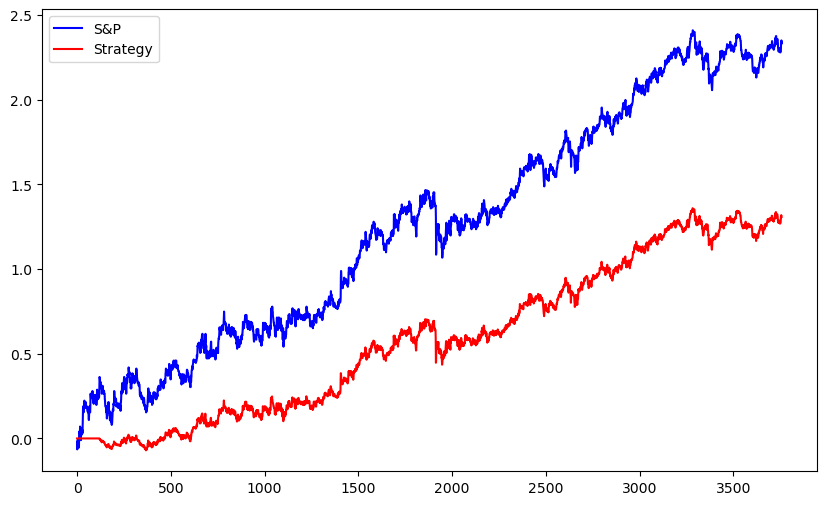

In [1385]:
# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(log_returns)), np.cumsum(log_returns), label='S&P', color='blue')
plt.plot(np.arange(len(portfolio_returns)), np.cumsum(portfolio_returns), label='Strategy', color='red')
plt.legend()
plt.show()

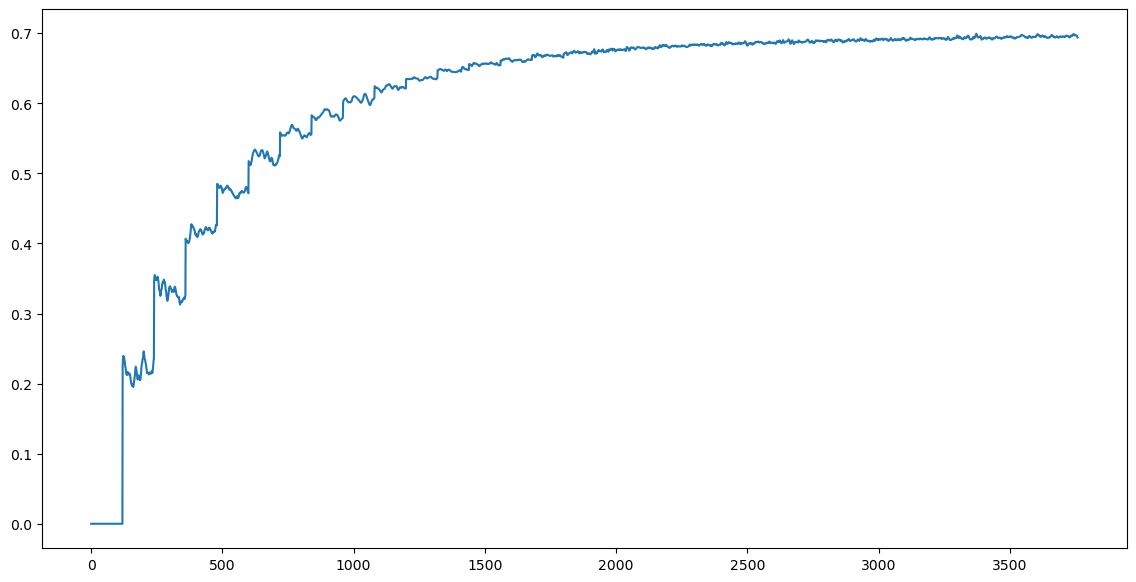

In [1386]:
plot(allocations)